In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [2]:
df_t = load_iedb_tcellepitopes()

In [3]:
S = 20
k = 9

Ntot = S**k
Nn = k*(S-1)

In [4]:
counter9 = count_kmers_proteome(human, k, clean=True)
human9 = set(counter9)
Nhuman = len(human9)

In [5]:
Nhuman/sum(counter9.values())

0.9165020031878309

In [6]:
counterm9 = count_kmers_proteome(proteome_path('Mouse'), k, clean=True)
mouse9 = set(counterm9)

In [7]:
df_t['Host', 'Name'].value_counts()

Homo sapiens                                 208781
Mus musculus C57BL/6                          29792
Mus musculus BALB/c                           20713
Mus musculus                                   5414
Homo sapiens Caucasian                         3969
                                              ...  
Mus musculus C57BL/6 F5 TCR Tg RAG-1 null         1
Mus musculus TGF-beta1                            1
Rattus norvegicus WAG                             1
Mus musculus C3H.JK                               1
Mus musculus BXSB                                 1
Name: (Host, Name), Length: 587, dtype: int64

In [8]:
np.sum(df_t['Host', 'Name'].str.contains('Mus musculus', na=False)), np.sum(df_t['Host', 'Name'].str.contains('Homo sapiens', na=False))

(104748, 212825)

In [9]:
# only human hosts
mask = df_t['Host', 'Name'].str.contains('Homo sapiens', na=False)
# no human epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=True)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
d = df_t[mask]
d['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             15122
Occurrence of infectious disease                                                    5965
Exposure with existing immune reactivity without evidence for disease               3684
Environmental exposure to endemic/ubiquitous agent without evidence for disease     2664
No immunization                                                                      994
Documented exposure without evidence for disease                                     244
Exposure without evidence for disease                                                147
Occurrence of autoimmune disease                                                      94
Occurrence of cancer                                                                  89
Occurrence of allergy                                                                 55
Occurrence of disease                                                                 24
Unknown              

In [10]:
mask = df_t['Host', 'Name'].str.contains('Mus musculus', na=False)
df_t[mask]['Epitope', 'Parent Species'].value_counts().head()

Mus musculus                                   11569
Vaccinia virus                                  9686
Homo sapiens                                    9411
Influenza A virus                               6885
Lymphocytic choriomeningitis mammarenavirus     5211
Name: (Epitope, Parent Species), dtype: int64

## Response frequency as a function of distance

In [11]:
host = 'Homo sapiens'
exclude = host
selfset = human9

In [12]:
#host = 'Mus musculus C57BL/6'
#exclude = 'Mus musculus'
#selfset = mouse9

In [13]:
# only specified hosts
mask = df_t['Host', 'Name'].str.contains(host, na=False)
#mask &= ~df_t['Host', 'Name'].str.contains('HLA', na=False)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(exclude, na=True)
d = df_t[mask]

In [14]:
dg = d.groupby(('Epitope', 'Description'))

In [15]:
d.columns = [' '.join(col).strip() for col in d.columns.values]

In [16]:
d['Assay Qualitative Measure'] = d['Assay Qualitative Measure'] == 'Negative'

<ipython-input-16-34b64c3fd5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Assay Qualitative Measure'] = d['Assay Qualitative Measure'] == 'Negative'


In [17]:
dfaq = d.groupby('Epitope Description')['Assay Qualitative Measure'].mean()

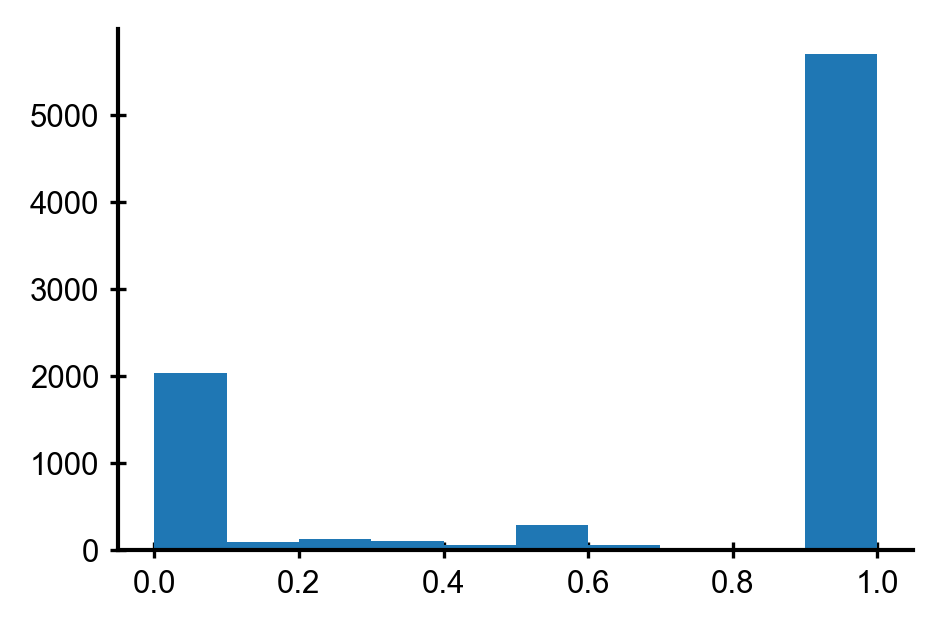

In [18]:
plt.hist(dfaq);

In [ ]:
# only specified hosts
mask = df_t['Host', 'Name'].str.match(host, na=False)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(exclude, na=True)
mask = ~(df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease')
d = df_t[mask]
# uniquify epitopes by keeping only the first one
d = d.groupby(('Epitope', 'Description')).apply(lambda x: x.iloc[0])
d0 = d['Epitope', 'Description'].apply(lambda x: x in selfset)
count0 = np.sum(d0)
d1 = d['Epitope', 'Description'].apply(lambda x: dist1(x, selfset)) & (~d0)
count1 = np.sum(d1)
d2 = d['Epitope', 'Description'].apply(lambda x: dist2(x, selfset)) & (~d0) & (~d1)
count2 = np.sum(d2)
pos0 = d[d0][~(d[d0]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
pos1 = d[d1][~(d[d1]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
pos2 = d[d2][~(d[d2]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
posall = d[(~(d['Assay', 'Qualitative Measure'] == 'Negative')) & (~d0) & (~d1) & (~d2)].shape[0]
ns = np.array([count0, count1, count2, d.shape[0]-count0-count1-count2])
ps = np.array([pos0, pos1, pos2, posall])/ns
ns, ps

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
ax.errorbar(range(4), ps, (ps*(1-ps)/ns)**.5)
ax.set_ylim(0, 0.45)
ax.set_xlabel('Distance to self')
ax.set_ylabel('Fraction positive assay')
fig.tight_layout()
fig.savefig('main.png' if exclude == 'Homo sapiens' else exclude + '.png')
fig.savefig('distance_vs_response.pdf')

## Nearest neighbor frequencies using human statistics

In [ ]:
df = Counter(human, 1).to_df(norm=True, clean=True)
pi = np.asarray(df['freq'])

psigmas = []
nsigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)

p0 = 1/Ntot
pp = Ntot*np.mean(psigmas**2)
print(pp, p0)
n0 = Nn/Ntot
n = Ntot*np.mean(psigmas*nsigmas)
print(n0, n)

In [ ]:
tripletparams = calc_tripletmodelparams(human)

In [ ]:
ptri = lambda seq: 10**loglikelihood_triplet(map_numbertoaa(seq), **tripletparams)


In [ ]:
psigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    psigmas.append(psigma)
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
psigmas = np.asarray(psigmas)

pptri = Ntot*np.mean(psigmas**2)
pptri

In [ ]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

In [ ]:
psigmas = []
nsigmas = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    nsigma = np.sum(np.fromiter((ptri(sigmap) for sigmap in neighbors(sigma, S)), np.float))
    psigmas.append(psigma)
    nsigmas.append(nsigma)
psigmas = np.asarray(psigmas)
nsigmas = np.asarray(nsigmas)

pptri = Ntot*np.mean(psigmas**2)
ntri = Ntot*np.mean(psigmas*nsigmas)
print(pptri, ntri/Nn)

In [ ]:
# only human hosts
mask = df_t['Host', 'Name'].str.contains('Homo sapiens', na=False)
# no epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].isna()
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9

mask_noh = mask[:]
mask_noh &= ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=True)
mask1 = mask_noh[:]
mask1 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask2 = mask_noh[:]
mask2 &= df_t['Assay', 'Qualitative Measure'] == 'Negative'

mask_noh &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask3 = mask_noh[:]
mask3 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of infectious disease'
mask4 = mask_noh[:]
mask4 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of allergy'
mask5 = mask.copy()
mask5 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask5 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease'
mask5 &= df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=False)
mask6 = mask[:]
mask6 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask6 &= (df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of cancer')

In [ ]:
Nhuman_tot = sum(val for val in counter9.values())
Nhuman_tot, Nhuman

In [ ]:
cases = [('positive', mask1),
         ('negative', mask2),
         ('pos infectious', mask3),
         ('pos cancer', mask6),
        ]
fig, axes = plt.subplots(figsize=(3.42, 2.0*len(cases)), nrows=len(cases), sharex=False)
for i, (name, mask) in enumerate(cases):
    print(name)
    ax = axes[i]
    d = df_t[mask]
    d0 = d['Epitope', 'Description'].apply(lambda x: x in human9)
    count0 = np.sum(d0)
    count1 = np.sum(d['Epitope', 'Description'].apply(lambda x: dist1(x, human9)) & (~d0))
    print(count0, count1)
    ax.axvline(count1/d.shape[0], c='k')
    ax.set_title(name + ' N = %g' % d.shape[0])
    xmax = 0.05
    x = np.arange(0, xmax*d.shape[0])
    Ncomp = d.shape[0]*Nhuman
    mu = Ncomp*n0
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='flat')
    mu = Ncomp*n
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='independent')
    mu = Ncomp*ntri
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='tri')
    ax.set_ylim(0.0)
    ax.set_xlim(0.0, xmax)
    ax.set_yticks([])
ax.set_xlabel('Peptides at distance 1 to self')
fig.tight_layout()

In [25]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

In [20]:
human_9mers = np.array(list(human9))

In [21]:
def distance_distribution(sample, selfset):
    d0 = np.array([x in selfset for x in sample])
    count0 = np.sum(d0)
    d1 = np.array([dist1(x, selfset) for x in sample]) & (~d0)
    count1 = np.sum(d1)
    d2 = np.array([dist2(x, selfset) for x in sample]) & (~d1) & (~d0)
    count2 = np.sum(d2)
    ns = np.array([count0, count1, count2, len(sample)-count0-count1-count2])
    return ns

In [22]:
humansample = set(np.random.choice(human_9mers, 5000))
ns_self = distance_distribution(humansample, set(human9)-humansample)

In [ ]:
pb1ufo = set(count_kmers_proteome(datadir + 'cancer/pb1ufo.fasta.gz', k))
ns_ufo = distance_distribution(pb1ufo, human9)

In [ ]:
len(pb1ufo)

In [ ]:
frameshifts = set(count_kmers_proteome(datadir + 'cancer/frameshifts.fasta.gz', k))
len(frameshifts)

In [ ]:
ns_frameshifts = distance_distribution(np.random.choice(np.array(list(frameshifts)), 5000), human9)

NameError: name 'ns' is not defined

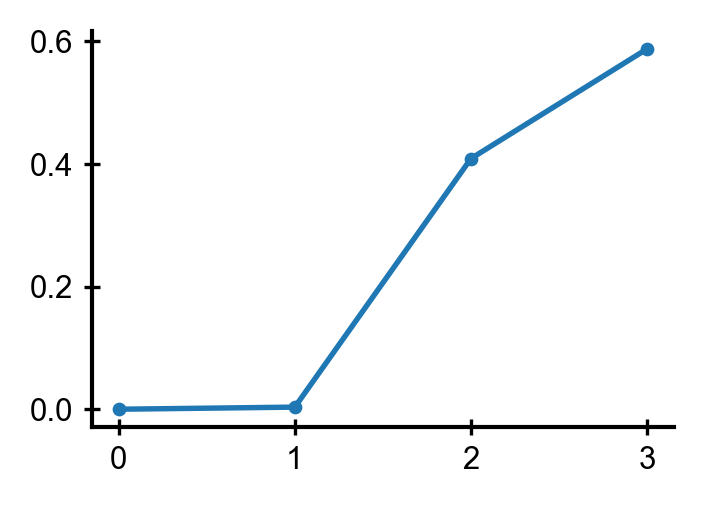

In [26]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
N = len(human9)
k = 9
d, p = nndist_probability(k, N)
ax.plot(d[:4], [p[0], p[1], p[2], np.sum(p[3:])], '-o', label='uniform')
ax.plot(range(4), ns/np.sum(ns), '-o', label='epitopes')
#ax.plot(range(4), ns_ufo/np.sum(ns_ufo), '-o', label='ufo')
#ax.plot(range(4), ns_frameshifts/np.sum(ns_frameshifts), '-o', label='frameshifts')
ax.plot(range(1, 4), ns_self[1:]/np.sum(ns_self[1:]), '-o', label='self')
#ax.plot([0, 1], [pptri*N, ntri*N], '-o')
ax.set_ylim(1e-5, 1)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Fraction')
ax.set_xlabel('Distance to self')
fig.savefig('neighbors.svg')

# Analysis of flu epitopes

In [ ]:
fluepis = df_t[df_t['Epitope', 'Parent Species'] == 'Influenza A virus']#['Epitope', 'Description'].unique()
fluepis.shape

In [ ]:
fluepis['Epitope', 'Description'].unique().shape

In [ ]:
plt.hist([len(s) for s in fluepis['Epitope', 'Description'].unique()], bins=np.arange(8, 21))

In [ ]:
nchunks = 100
btdist = BallTreeDist(human9, nchunks=nchunks)

In [ ]:
fluepis9 = fluepis[fluepis['Epitope', 'Description'].apply(len)==9]
#list(fluepis9['Epitope', 'Description'].unique())

In [ ]:
fludists = [btdist.mindist(e) for e in list(fluepis9['Epitope', 'Description'].unique())]

In [ ]:
np.histogram(fludists, np.arange(0, 6))

In [ ]:
proteomes = load_proteomes()


In [ ]:
df_flua = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['InfluenzaA']['path'], 9), norm=True)
df_flua.head()

In [ ]:
distss = []
for i in range(3):
    peptides = np.random.choice(df_flua['seq'], size=int(len(fludists)), replace=False, p=df_flua['freq'])
    dists = [btdist.mindist(e) for e in peptides]
    distss.append(dists)

In [ ]:
counts = np.bincount(fludists)
print(counts)
plt.plot(counts, 'o')
for d in [distss[0], distss[1], distss[2]]:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
def dists_direct(df, ref):
    d0 = df[df['seq'].apply(lambda x: x in ref)].shape[0]/df['seq'].shape[0]
    d1 = df[df['seq'].apply(dist1)].shape[0]/df['seq'].shape[0]
    d2 = df[df['seq'].apply(dist2)].shape[0]/df['seq'].shape[0]
    return d0, d1, d2

In [ ]:
distsallflu = dists_direct(df_flua, human9)

In [ ]:
counts = np.bincount(fludists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallflu, 'x')

N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)

In [ ]:
hivepis = d[d['Epitope', 'Parent Species'] == 'Human immunodeficiency virus 1']['Epitope', 'Description'].unique()
hivepis.shape

In [ ]:
hivdists = [mindist_sklearn_chunked(e, bts) for e in hivepis]

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'x')

In [ ]:
df_hiv1 = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['HIV']['path'], 9), norm=True)
df_hiv1.head()

In [ ]:
distss_hiv = []
for i in range(3):
    peptides = np.random.choice(df_hiv1['seq'], size=len(hivdists), replace=False, p=df_hiv1['freq'])
    dists = [mindist_sklearn_chunked(e, bts) for e in peptides]
    distss_hiv.append(dists)

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'o')
for d in distss_hiv:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
distsallhiv = dists_direct(df_hiv1, human9)

In [ ]:
counts = np.bincount(hivdists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallhiv, 'x')
N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = lambda d: 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc(dists)*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)